# Retrieve imdbID from a CSV list of directors

In [1]:
import numpy as np
import pandas as pd
import time
from bs4 import BeautifulSoup
import json
import requests
import random

In [24]:
# Loading 90k directors who made the 350k movies
df = pd.read_csv("90 000 directors awards.csv", encoding='utf-8', sep=",",index_col=0)
df[:5]

,director_name,gender,movies_nb,fidelity_rel,fidelity_abs,awards_retrieved,tmdbID,imdbID
0,Aki Kaurismäki,2.0,30,2.1,62,0,0,0
1,Allison Anders,1.0,9,0.2,2,0,0,0
2,Stephen Hopkins,2.0,14,0.5,7,0,0,0
3,Timo Novotny,2.0,5,0.0,0,0,0,0
4,Marc Meyer,2.0,2,0.0,0,0,0,0


In [ ]:
storage_frequency=5000
processed=0

for i in range(len(df)):
    if df.loc[i,"imdbID"]==0:
        director = df.loc[i,"director_name"].replace(" ","%20")

        #let's get tmdb_id from director_name
        query_for_tmdbID = "https://api.themoviedb.org/3/search/person?api_key=04fe0efd7c6e8c505128686c70ae5825&query="+director
        results = requests.get(query_for_tmdbID)
        dic_results = json.loads(results.text)
        try:
            tmdbID = dic_results["results"][0]["id"]
            #let's get imdb_id from tmdb_id
            query_for_imdbID = "https://api.themoviedb.org/3/person/"+str(tmdbID)+"/external_ids?api_key=04fe0efd7c6e8c505128686c70ae5825"
            results = requests.get(query_for_imdbID)
            dic_results = json.loads(results.text)
            imdbID = dic_results["imdb_id"]

        except:
            tmdbID=0
            imdbID=0

        print(director+"["+str(i)+"]:imdbID = "+imdbID)
        df.loc[i,"tmdbID"]=tmdbID
        df.loc[i,"imdbID"]=imdbID

        processed+=1
        #save file every 5000 exec in case it crashes
        if processed>storage_frequency:
            processed=0
            df.to_csv("90 000 directors awards.csv", encoding='utf-8', sep=",")
        

Aki%20Kaurismäki[0]:imdbID = nm0442454
Allison%20Anders[1]:imdbID = nm0025978
Stephen%20Hopkins[2]:imdbID = nm0394280
Timo%20Novotny[3]:imdbID = nm1119183
Marc%20Meyer[4]:imdbID = nm0583259
George%20Lucas[5]:imdbID = nm0000184
Andrew%20Stanton[6]:imdbID = nm0004056
Robert%20Zemeckis[7]:imdbID = nm0000709
Sam%20Mendes[8]:imdbID = nm0005222
Orson%20Welles[9]:imdbID = nm0000080
Lars%20von%20Trier[10]:imdbID = nm0001885
John%20Fawcett[11]:imdbID = nm0269502
Luc%20Besson[12]:imdbID = nm0000108
Fritz%20Lang[13]:imdbID = nm0000485
Isabel%20Coixet[14]:imdbID = nm0170043
Bruce%20Brown[15]:imdbID = nm0113164
Gore%20Verbinski[16]:imdbID = nm0893659
Quentin%20Tarantino[17]:imdbID = nm0000233
Eytan%20Fox[18]:imdbID = nm0297202
Michael%20Winterbottom[19]:imdbID = nm0935863
Francis%20Ford%20Coppola[20]:imdbID = nm0000338
Kôji%20Morimoto[21]:imdbID = nm0605479
Tensai%20Okamura[22]:imdbID = nm0645515
Katsuhiro%20Ōtomo[23]:imdbID = nm0960028
Clint%20Eastwood[24]:imdbID = nm0000142
David%20Silverman[25]:

In [ ]:
df.to_csv("mydirectors_name_and_imdbID.csv", encoding='utf-8-sig',sep=";")

In [8]:
director_name="Jackie Chan"

#let's get tmdb_id from director_name
director = director_name.replace(" ","%20")
query_for_tmdbID = "https://api.themoviedb.org/3/search/person?api_key=04fe0efd7c6e8c505128686c70ae5825&query="+director
results = requests.get(query_for_tmdbID)
dic_results = json.loads(results.text)
try:
    tmdbID = dic_results["results"][0]["id"]

    #let's get imdb_id from tmdb_id
    query_for_imdbID = "https://api.themoviedb.org/3/person/"+str(tmdbID)+"/external_ids?api_key=04fe0efd7c6e8c505128686c70ae5825"
    results = requests.get(query_for_imdbID)
    dic_results = json.loads(results.text)
    imdbID = dic_results["imdb_id"]
    print(str(i)+","+director+":imdbID = "+imdbID)
except:
    print("director not found")


39,Jackie%20Chan:imdbID = nm0000329


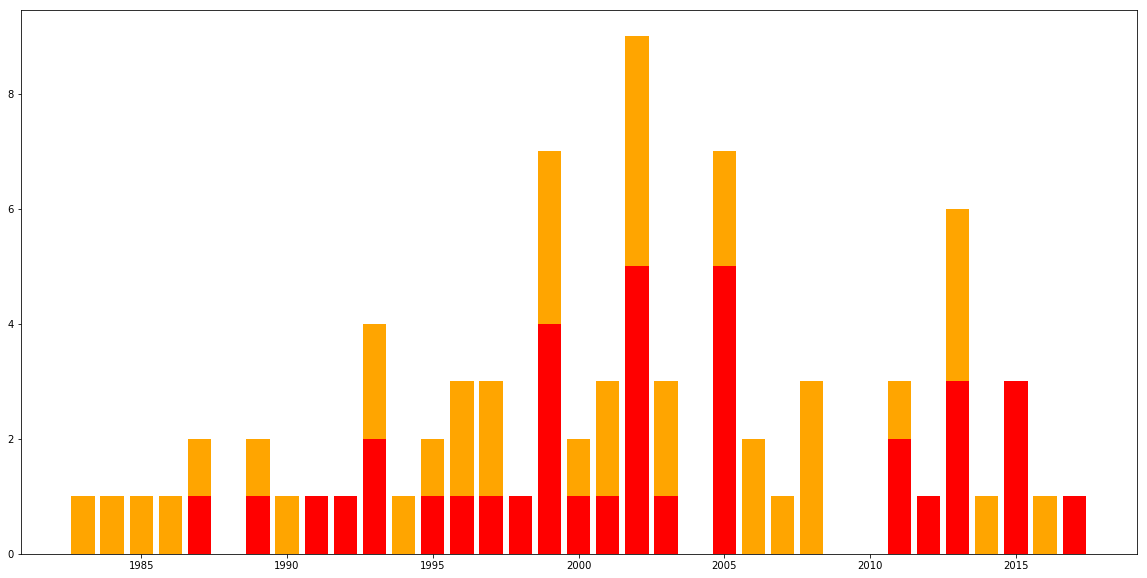

In [9]:
#query IMDB
url = "http://www.imdb.com/name/"+imdbID+"/awards"
r  = requests.get(url)
data = r.text
soup = BeautifulSoup(data,"lxml")

df_award=pd.DataFrame(columns=['name','ceremony','year','category','outcome'])

# Find all of the text between paragraph tags and strip out the html
itag=0
collection_tag =soup.find_all()
while itag<len(collection_tag):
    tag=collection_tag[itag]
    tagtext = tag.text.lower()
    #We stop at each award_ceremony, to get all award_years
    if tag.name=="h3" and director_name.lower() not in tagtext and "imdb" not in tagtext and "user" not in tagtext :
        ceremony = tag.text
        #let's go through each year and stop at next H3 tag
        allow_next=True
        while allow_next:
            itag+=1
            tag=collection_tag[itag]
            #let's go through all tags and find outcome(s)/category(s) for each year
            stay_on_tag=True
            for key,value in tag.attrs.items():
                if not stay_on_tag:
                    break
                if key=="class":
                    if value[0]=="award_year":
                        year=int(collection_tag[itag].text)
                        stay_on_tag=False
                    elif value[0]=="award_outcome":                        
                        outcome=collection_tag[itag+1].text
                    elif value[0]=="award_category":
                        category=collection_tag[itag].text
                        #we should have a complete row : name / ceremony / category / outcome
                        new_row=len(df_award)+1
                        df_award.loc[new_row,["name"]]=director_name
                        df_award.loc[new_row,["ceremony"]]=ceremony
                        df_award.loc[new_row,["year"]]=year
                        df_award.loc[new_row,["category"]]=category
                        df_award.loc[new_row,["outcome"]]=outcome
                        
            #if you bump on a next ceremony come back one step before and analyse it
            if tag.name=="h3":
                allow_next=False
                itag-=1
    itag+=1
df_award[-5:]

#count won & nominated
df_award["simplified_outcome"]="Nominated"
df_award.loc[df_award["outcome"]=="Won","simplified_outcome"]="Won"
group = df_award.groupby(by=["year","simplified_outcome"]).count()

#chart won & nominated
min_year=df_award["year"].min()
max_year=df_award["year"].max()+1

won_serie=pd.Series(index=range(min_year,max_year))
nominated_serie=pd.Series(index=range(min_year,max_year))

for i in range(min_year,max_year):
    won_serie[i]=0
    nominated_serie[i]=0

for i in range(len(group.index)):
    if group.index[i][1]=="Won":
        won_serie[group.index[i][0]]=group.iloc[i]["name"]
    if group.index[i][1]=="Nominated":
        nominated_serie[group.index[i][0]]=group.iloc[i]["name"]
        
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.bar(range(min_year,max_year), won_serie, color = 'red')
plt.bar(range(min_year,max_year), nominated_serie, color = 'orange', bottom = won_serie)
plt.show()

In [ ]:
##### df["queried"]=0
df["awards_total"]=0


#Let's retrieve the awards from imdb
for i in range(len(df)):
    imdbID = str(df.loc[i,"imdbID"])
    awards_total=0
    if imdbID[0:2]=="nm" and df.loc[i,"queried"]==0:
        #query IMDB
        url = "http://www.imdb.com/name/"+imdbID+"/awards"
        r  = requests.get(url)
        data = r.text
        soup = BeautifulSoup(data,"lxml")

        #Browse for awards
        for tag in soup.find_all('td', class_='award_outcome'):
            award_name = tag.find_all('span',class_='award_category')[0].text
            outcome = tag.find_all('b')[0].text

            #check for existence of award column else create it
            if df.columns.contains(award_name)==False:
                df[award_name]=0
            if df.columns.contains(award_name+"_won")==False:
                df[award_name+"_won"]=0
            if df.columns.contains(award_name+"_nominated")==False:
                df[award_name+"_nominated"]=0

            #count awards won & nominated & sum
            df.loc[i,award_name]+=1
            awards_total+=1
            if outcome.lower()=="won":
                df.loc[i,award_name+"_won"]+=1
            if outcome.lower()=="nominated":
                df.loc[i,award_name+"_nominated"]+=1

        print(df.loc[i,"name"]+", found "+str(awards_total)+" total awards")
        df.loc[i,"queried"]=1
        df.loc[i,"awards_total"]=awards_total
        #Avoid spamming imdb
        time.sleep(random.random()*10)

In [69]:
df.shape

(999, 6676)